In [1]:
import numpy as np
import einops
import tensorflow as tf
import tensorflow_text as tf_text
import tensorflow as tf
gpu_list = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_list) > 0:
    for gpu in gpu_list:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e) 
else:
    print("Got no gpus")

D:\anaconda\envs\tf-gpu-2.10.0-py-3.10\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\anaconda\envs\tf-gpu-2.10.0-py-3.10\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
D:\anaconda\envs\tf-gpu-2.10.0-py-3.10\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import logging
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_text

D:\anaconda\envs\tf-gpu-2.10.0-py-3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MAX_TOKENS=128
BUFFER_SIZE = 20000
BATCH_SIZE = 64
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',  with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(f'{model_name}.zip', f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip', cache_dir='.', cache_subdir='', extract=True )
tokenizers = tf.saved_model.load(model_name)

def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    pt = pt[:, :MAX_TOKENS].to_tensor()
    en = tokenizers.en.tokenize(en)
    en = en[:, :MAX_TOKENS+1]
    en_inputs = en[:,:-1].to_tensor()
    en_labels = en[:, 1:].to_tensor()
    return (pt, en_inputs), en_labels

train_batches =  train_examples.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).map(prepare_batch, tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_batches =  val_examples.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).map(prepare_batch, tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)
for (e,i),o in train_batches.take(1):
    print(e[:1])
    print(i[:1])
    print(o[:1])

tf.Tensor(
[[   2  120   85  979  103   95 4160   16    3    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]], shape=(1, 73), dtype=int64)
tf.Tensor(
[[   2   96   80   37  622   74 3456 3921   15    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 81), dtype=int64)
tf.Tensor(
[[  96   80   37  622   74 3456 3921   15    3    0    0    0    0    0
     0    0    0    0    0    0    0   

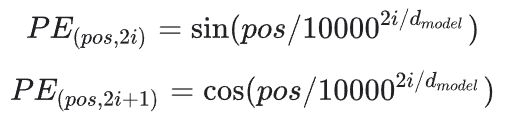

In [4]:
def positional_encoding(length, depth):
    depth = depth / 2
    positions = np.arange(length)[:, np.newaxis]   # 位置 (length, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth   # 深度 (1, depth)
    angle_rates = 1 / (10000 ** depths)
    angle_rads = positions * angle_rates
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
#     pos_encoding = np.zeros((length, depth * 2))
#     pos_encoding[:, 0::2] = np.sin(angle_rads)  # 2i: 偶数位置
#     pos_encoding[:, 1::2] = np.cos(angle_rads)  # 2i+1: 奇数位置
    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)
    
    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, : length, :]
        return x

In [5]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)
        self.last_attn_scores = attn_scores
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x
    
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x, use_causal_mask=True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()
    
    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

In [6]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff)
    
    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.pos_embedding = PositionEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x):
        x =self.pos_embedding(x)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
        return x

In [7]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
        self.causal_self_attention = CausalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.cross_attention = CrossAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff)
        
    def call(self, x, context):
        x = self.causal_self_attention(x)
        x = self.cross_attention(x=x, context=context)
        self.last_attn_scores = self.cross_attention.last_attn_scores
        x = self.ffn(x)
        return x

class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.pos_embedding = PositionEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
        self.last_attn_scores = None
    
    def call(self, x, context):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, context)
        self.last_attn_scores = self.dec_layers[-1].last_attn_scores
        return x

In [8]:
decoder = Decoder(num_heads=1, num_layers=1, d_model=512, dff=2048, vocab_size=tokenizers.en.get_vocab_size())
context=tf.constant(shape=(3,10,256), value=1.)
x = tf.constant(shape=(3,15), value=1.)
decoder(x, context)

<tf.Tensor: shape=(3, 15, 512), dtype=float32, numpy=
array([[[ 0.74893034, -1.6052595 , -0.3994048 , ...,  1.963297  ,
         -1.6808728 , -0.13937518],
        [ 1.8466887 , -0.85400987,  0.5228292 , ...,  2.0004137 ,
         -1.6961007 , -0.1371011 ],
        [ 1.9615678 , -0.69911665,  0.7384652 , ...,  2.06872   ,
         -1.4438744 , -0.09579261],
        ...,
        [ 0.37530485, -2.0800292 , -0.79535043, ...,  2.203009  ,
         -0.92917895,  0.27189368],
        [ 1.3792925 , -1.4013275 , -0.23600182, ...,  2.1121204 ,
         -0.8000585 ,  0.28068957],
        [ 1.8966008 , -0.7115123 ,  0.66725963, ...,  1.950827  ,
         -0.8372355 ,  0.20123897]],

       [[ 0.74893034, -1.6052595 , -0.3994048 , ...,  1.963297  ,
         -1.6808728 , -0.13937518],
        [ 1.8466887 , -0.85400987,  0.5228292 , ...,  2.0004137 ,
         -1.6961007 , -0.1371011 ],
        [ 1.9615678 , -0.69911665,  0.7384652 , ...,  2.06872   ,
         -1.4438744 , -0.09579261],
        ...,


In [9]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)
        self.decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=target_vocab_size, dropout_rate=dropout_rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        x = self.decoder(x , context)
        logits = self.final_layer(x)
        try:
            del logits._keras_mask
        except AttributeError:
            pass
        return logits
    
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
transformer = Transformer(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,input_vocab_size=tokenizers.pt.get_vocab_size().numpy(), target_vocab_size=tokenizers.en.get_vocab_size(), dropout_rate=dropout_rate)

In [10]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred
    mask = label != 0
    match = match & mask
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match) / tf.reduce_sum(mask)


learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1 = 0.9, beta_2=0.98, epsilon=1e-9)
transformer.compile(loss = masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
transformer.fit(train_batches, epochs=20, validation_data=val_batches)

Epoch 1/20
810/810 [==============================] - 39s 43ms/step - loss: 6.5996 - masked_accuracy: 0.1469 - val_loss: 5.0464 - val_masked_accuracy: 0.2479
Epoch 2/20
810/810 [==============================] - 55s 67ms/step - loss: 4.5725 - masked_accuracy: 0.2976 - val_loss: 4.0441 - val_masked_accuracy: 0.3606
Epoch 3/20
810/810 [==============================] - 45s 56ms/step - loss: 3.8208 - masked_accuracy: 0.3799 - val_loss: 3.4296 - val_masked_accuracy: 0.4349
Epoch 4/20
810/810 [==============================] - 33s 41ms/step - loss: 3.2628 - masked_accuracy: 0.4421 - val_loss: 3.0187 - val_masked_accuracy: 0.4844
Epoch 5/20
810/810 [==============================] - 35s 43ms/step - loss: 2.8651 - masked_accuracy: 0.4871 - val_loss: 2.7249 - val_masked_accuracy: 0.5195
Epoch 6/20
810/810 [==============================] - 32s 40ms/step - loss: 2.5505 - masked_accuracy: 0.5261 - val_loss: 2.4583 - val_masked_accuracy: 0.5528
Epoch 7/20
810/810 [==============================] 

In [11]:
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer
    
    def __call__(self, sentence, max_length=MAX_TOKENS):
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]
        sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
        encoder_input = sentence
        start_end = self.tokenizers.en.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0 , start)
        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer([encoder_input, output], training=False)
            predictions = predictions[:, -1:, :]
            predicted_id = tf.argmax(predictions, axis=-1)
            output_array = output_array.write(i+1, predicted_id[0])
            if predicted_id == end:
                break
        output = tf.transpose(output_array.stack())
        text = tokenizers.en.detokenize(output)[0]
        tokens = tokenizers.en.lookup(output)[0]
        self.transformer([encoder_input, output[:, :-1]], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores
        return text, tokens, attention_weights

In [12]:
translator = Translator(tokenizers, transformer)
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')
    
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


In [13]:
class Translators(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer
    
    def __call__(self, sentences, max_length=MAX_TOKENS):
        assert isinstance(sentences, tf.Tensor)
        batch_size = tf.shape(sentences)[0]
        sentences = self.tokenizers.pt.tokenize(sentences).to_tensor()
        encoder_input = sentences
        start_end = self.tokenizers.en.tokenize([''])[0]
        start = tf.fill([batch_size, 1], start_end[0])
        end = start_end[1]
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)
        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack(), perm=[1, 0, 2])
            predictions = self.transformer([encoder_input, tf.squeeze(output, axis=-1)], training=False)  # [B,1,V]
            predictions = predictions[:, -1:, :]
            predicted_id = tf.argmax(predictions, axis=-1)
            done |= predicted_id == end
            predicted_id = tf.where(done, tf.constant(0, dtype=tf.int64), predicted_id)  # [B, 1]
            output_array = output_array.write(i+1, predicted_id)
            if tf.reduce_all(done):
                break
        
        output = tf.transpose(output_array.stack(), perm=[1, 0, 2])
        output = tf.squeeze(output, axis=-1)  # Remove the last dimension
        
        text = self.tokenizers.en.detokenize(output)
        tokens = self.tokenizers.en.lookup(output)
        
        return text, tokens


In [143]:
translators = Translators(tokenizers, transformer)
 
sentences = [ 'este é um problema que temos que resolver.',  # 'this is a problem we have to solve .'
 'os meus vizinhos ouviram sobre esta ideia.',  # 'and my neighboring homes heard about this idea .'
  'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.' #"so i'll just share with you some stories very quickly of some magical things that have happened."
  ]
ground_truths = ['this is a problem we have to solve .', 'and my neighboring homes heard about this idea .', "so i'll just share with you some stories very quickly of some magical things that have happened."]
translated_text, translated_tokens = translators( tf.constant(sentences) )
def print_translation(sentences, preds, ground_truths):
    for s,t,g in zip(sentences, preds, ground_truths):
        print(f'{"Input:":15s}: {s}')
        print(f'{"Prediction":15s}: {t.numpy().decode("utf-8")}')
        print(f'{"Ground truth":15s}: {g}')
        print('\n')
print_translation(sentences, translated_text, ground_truths)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to be very rapidly in sharing some of the magic stories that happened .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


